In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/pilot_LUAD/gdc_sample_sheet.2019-12-09.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,c5b283b8-a6ab-4652-b824-18fe1cebe0e3,0bf53fc6-b8fb-4e6d-9297-4129c708f3da.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-50-5935,TCGA-50-5935-01A,Primary Tumor,FPKM
1,27079945-f3da-42b4-8c17-c82d66b7d321,f4a1e772-2a5e-4c0a-803a-1bdb2b376a47.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-55-6971,TCGA-55-6971-11A,Solid Tissue Normal,FPKM-UQ
2,da368838-dad0-434d-a2a8-084b362e358e,12d2b9fa-1921-4033-bdb9-7e114c0d7812.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-99-8025,TCGA-99-8025-01A,Primary Tumor,FPKM
3,be46ee72-8958-483f-bd54-38d21ebf7ff6,4d36e127-5fad-4b97-afff-28f4bdbf5f5d.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-55-8301,TCGA-55-8301-01A,Primary Tumor,FPKM
4,c5f764bd-a9d4-4188-a4dc-a5e6ca1183f8,c57c5f57-5426-4662-832d-6f342ebeff04.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-73-4677,TCGA-73-4677-01A,Primary Tumor,FPKM-UQ


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

htseq      59
FPKM       59
FPKM-UQ    59
Name: data, dtype: int64

In [4]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [5]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & (samples['data']=='FPKM')]['Case ID'].nunique()

57

59

In [6]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & (samples['data']=='FPKM')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(57,)

In [7]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])
cases['Sample Type'] = cases['Sample Type'].astype('category')

In [8]:
case_tumor.shape
case_norm.shape
cases.shape

(67, 9)

(57, 9)

(124, 9)

## Dataset Prep

In [13]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          47
Solid Tissue Normal    46
Name: Sample Type, dtype: int64

Primary Tumor          20
Solid Tissue Normal    11
Name: Sample Type, dtype: int64

In [14]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
classes = train[target].cat.categories.values


Cuda is available: True


In [15]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/pilot_LUAD/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [16]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 3

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (0): Linear(in_features=60483, out_features=2000, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=500, out_features=2, bias=True)
    )
  )
)

In [18]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/93 (0%)]	Loss: 19.258451	Accuracy: 70.0
Train: [30/93 (30%)]	Loss: 44.418739	Accuracy: 57.5
Train: [60/93 (60%)]	Loss: 24.373591	Accuracy: 55.714285714285715
Train: [27/93 (90%)]	Loss: 43.444187	Accuracy: 52.68817204301075
Epoch: 1/20. Train set: Average loss: 35.5968	Accuracy: 52.68817204301075
Epoch: 1/20. Validation set: Average loss: 24.7127	Accuracy: 51.61290322580645
Train: [0/93 (0%)]	Loss: 13.358123	Accuracy: 70.0
Train: [30/93 (30%)]	Loss: 24.381800	Accuracy: 57.5
Train: [60/93 (60%)]	Loss: 40.261373	Accuracy: 55.714285714285715
Train: [27/93 (90%)]	Loss: 27.738400	Accuracy: 52.68817204301075
Epoch: 2/20. Train set: Average loss: 29.0503	Accuracy: 52.68817204301075
Epoch: 2/20. Validation set: Average loss: 23.5773	Accuracy: 51.61290322580645
Train: [0/93 (0%)]	Loss: 19.088079	Accuracy: 80.0
Train: [30/93 (30%)]	Loss: 38.074618	Accuracy: 60.0
Train: [60/93 (60%)]	Loss: 25.494815	Accuracy: 57.142857142857146
Train: [27/93 (90%)]	Loss: 74.170732	Accuracy: 54.8387096774

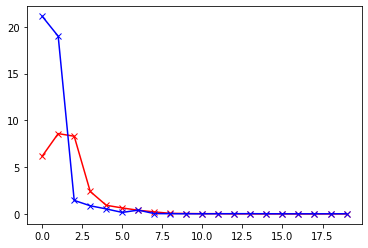

In [14]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

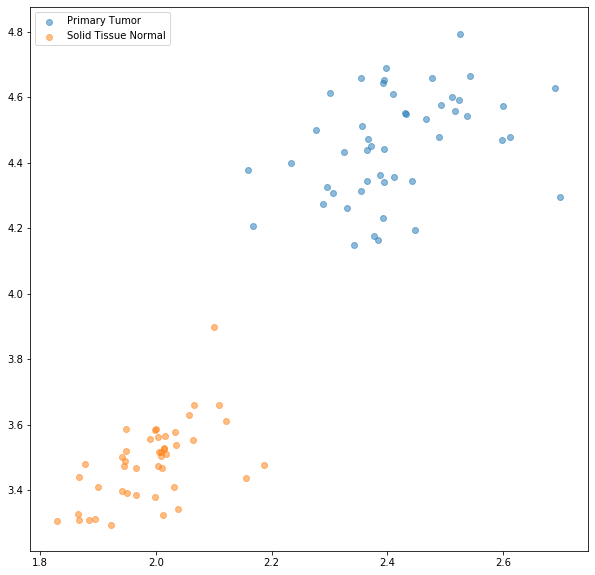

In [15]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

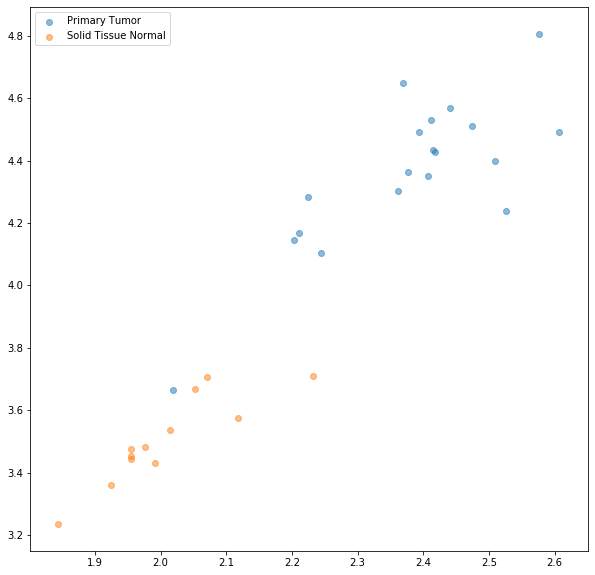

In [16]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

# Adverserial Testing
Shuffle labels and compare loss to true model.

In [18]:
adver = cases.copy()
np.random.shuffle(adver['Sample Type'].values)
assert np.equal(adver['Sample Type'].values, cases['Sample Type'].values).sum() != len(cases)

In [20]:
train, test = train_test_split(adver)
train['Sample Type'].value_counts()
test['Sample Type'].value_counts()

Primary Tumor          53
Solid Tissue Normal    40
Name: Sample Type, dtype: int64

Solid Tissue Normal    17
Primary Tumor          14
Name: Sample Type, dtype: int64

In [21]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
classes = train['Sample Type'].cat.categories.values

In [22]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/pilot_LUAD/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True)
test_dataset = TCGA(root_dir, samples=test, train=False)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [23]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 3

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (0): Linear(in_features=60483, out_features=2000, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=500, out_features=250, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=250, out_features=100, bias=True)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=100, out_features=50, bias=True)
      (9): PReLU(num_parameters=1)
      (10): Linear(in_features=50, out_features=10, bias=True)
      (11): PReLU(num_parameters=1)
      (12): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [24]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/93 (0%)]	Loss: 0.091314	Accuracy: 40.0
Train: [30/93 (30%)]	Loss: 4.356499	Accuracy: 55.0
Train: [60/93 (60%)]	Loss: 1.074280	Accuracy: 48.57142857142857
Train: [27/93 (90%)]	Loss: 7.058412	Accuracy: 53.763440860215056
Epoch: 1/20. Train set: Average loss: 3.7559	Accuracy: 53.763440860215056
Epoch: 1/20. Validation set: Average loss: 2.8996	Accuracy: 48.38709677419355
Train: [0/93 (0%)]	Loss: 9.679315	Accuracy: 30.0
Train: [30/93 (30%)]	Loss: 2.036904	Accuracy: 42.5
Train: [60/93 (60%)]	Loss: 6.025926	Accuracy: 42.857142857142854
Train: [27/93 (90%)]	Loss: 1.044980	Accuracy: 46.236559139784944
Epoch: 2/20. Train set: Average loss: 3.7003	Accuracy: 46.236559139784944
Epoch: 2/20. Validation set: Average loss: 7.9664	Accuracy: 48.38709677419355
Train: [0/93 (0%)]	Loss: 11.644698	Accuracy: 40.0
Train: [30/93 (30%)]	Loss: 2.996032	Accuracy: 47.5
Train: [60/93 (60%)]	Loss: 1.198075	Accuracy: 51.42857142857143
Train: [27/93 (90%)]	Loss: 3.749873	Accuracy: 54.83870967741935
Epoch: 3

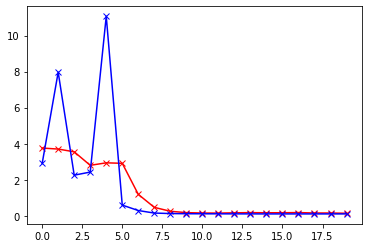

In [25]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

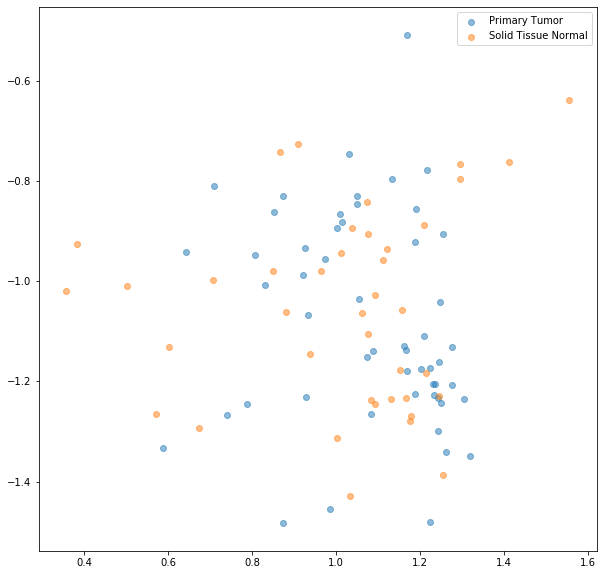

In [26]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

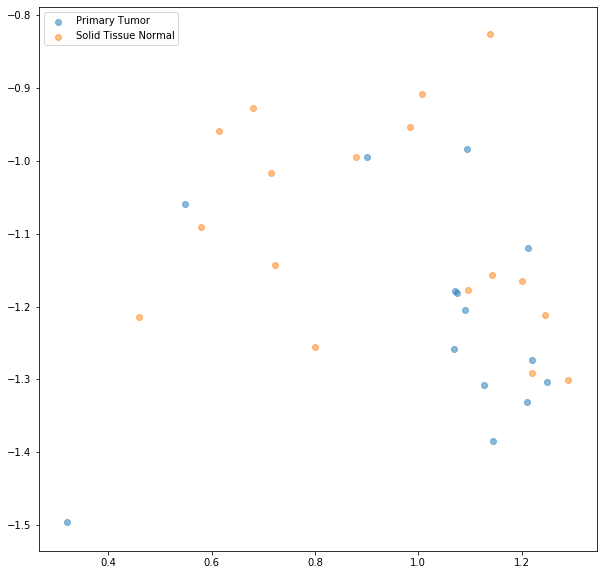

In [27]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)